<a href="https://colab.research.google.com/github/asrenninger/urbansim/blob/main/miscellany/amenities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt

In [36]:
iso2 = "GB"
world = gpd.read_file("drive/MyDrive/overture/ne/ne_10m_admin_0_countries.shp")
country = world[world.ISO_A2==iso2]
bounds = country.total_bounds

In [9]:
import duckdb
con = duckdb.connect(database=':memory:')

con.execute("INSTALL httpfs;")
con.execute("INSTALL spatial;")
con.execute("LOAD httpfs;")
con.execute("LOAD spatial;")

places_s3_path = "s3://fsq-os-places-us-east-1/release/dt=2025-02-06/places/parquet/*"

try:
    query = f"""
    SELECT
        fsq_place_id,
        name,
        latitude,
        longitude,
        address,
        locality,
        region,
        postcode,
        country,
        date_created,
        date_refreshed,
        date_closed,
        fsq_category_ids,
        fsq_category_labels,
        website,
        tel,
        email
    FROM
        read_parquet('{places_s3_path}')
    WHERE
        country = '{iso2}'
        AND date_closed IS NULL
    """

    print("Executing query...")
    df = con.execute(query).fetchdf()
    print(f"Retrieved {len(df)} POIs for {iso2}")
    df.to_csv(f"drive/MyDrive/overture/foursquare_pois_{iso2}.csv", index=False)

except Exception as e:
    print(f"Error executing query: {e}")

    # alternative approach using spatial bounds if country code doesn't work
    try:
        print("\nTrying with spatial bounds instead...")
        spatial_query = f"""
        SELECT
            fsq_place_id,
            name,
            latitude,
            longitude,
            address,
            locality,
            region,
            postcode,
            country,
            date_created,
            date_refreshed,
            date_closed,
            fsq_category_ids,
            fsq_category_labels
        FROM
            read_parquet('{places_s3_path}')
        WHERE
            latitude BETWEEN {bounds[1]} AND {bounds[3]}
            AND longitude BETWEEN {bounds[0]} AND {bounds[2]}
            AND date_closed IS NULL
        """

        df = con.execute(spatial_query).fetchdf()
        print(f"Retrieved {len(df)} POIs using spatial bounds")

        print("Executing query...")
        df = con.execute(query).fetchdf()
        print(f"Retrieved {len(df)} POIs for {iso2}")
        df.to_csv(f"drive/MyDrive/overture/foursquare_pois_{iso2}.csv", index=False)

    except Exception as spatial_error:
        print(f"Error with spatial query: {spatial_error}")

con.close()

Executing query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Retrieved 3795013 POIs for GB
Results saved to foursquare_pois_GB.csv

Sample data:
               fsq_place_id                    name  latitude  longitude  \
0  f31419128bba4fb69419c27f      Staybright Windows       NaN        NaN   
1  8a911c64780840e782fb00b0            Trade Carpet       NaN        NaN   
2  3da40ba6deda4ed255373edb     Red Hot Mini Buffet       NaN        NaN   
3  05db67909fe2455666d905ba  Orlando Bridge Carpets       NaN        NaN   
4  2693ec73d6604f2fbfe1cc9d                 Nouveau       NaN        NaN   

                             address    locality              region  \
0                     100 Sidwell St      Exeter               Devon   
1              33 Summerstown Unit 7      London      Greater London   
2                      124 London Rd   Leicester      Leicestershire   
3  Orlando Works, Thynne St Unit 1-4      Bolton  Greater Manchester   
4                   9 Stockbridge Rd  Winchester           Hampshire   

   postcode country date_c

In [13]:
df = df[~df['latitude'].isna() & ~df['longitude'].isna()]

In [5]:
# df.to_csv("drive/MyDrive/overture/fsq_places_GB.csv", index=False)

In [3]:
df = pd.read_csv("drive/MyDrive/overture/fsq_places_GB.csv")

In [4]:
df = df[~df['fsq_category_labels'].isna()]

In [5]:
import re
# there are a lot of errors in the schema
def parse_list(s):
    if not isinstance(s, str):
        return []

    # remove newline and carriage return characters
    s = s.replace("\n", " ").replace("\r", " ")

    # remove outer square brackets if they exist
    s = s.strip("[]")

    # insert a comma between adjacent quoted segments that have no separator.
    # this handles cases where one segment ends with a quote and the next starts with a quote.
    s = re.sub(r'([\'"])\s+(?=[\'"])', r'\1, ', s)

    # split the string by commas into segments.
    segments = re.split(r'\s*,\s*', s)

    final_list = []
    for seg in segments:
        # remove any stray leading/trailing quotes and extra spaces
        seg = seg.strip().strip('\'"')
        # normalize the separator: ensure " > " has one space on each side
        seg = re.sub(r'\s*>\s*', ' > ', seg)
        if seg:
            # now split by the normalized separator and add each level
            parts = [part.strip() for part in seg.split(" > ") if part.strip()]
            final_list.extend(parts)
    return final_list

df['categories'] = df['fsq_category_labels'].apply(parse_list)
df['levels'] = df['categories'].apply(len)
df.head()

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,country,date_created,date_refreshed,date_closed,fsq_category_ids,fsq_category_labels,website,tel,email,categories,levels
0,521f58b9498e79c38f905f3b,grill & pasta house,34.651498,32.975502,NaN,NaN,NaN,NaN,GB,2013-08-29,2020-07-11,NaN,['4bf58dd8d48988d10e941735'],['Dining and Drinking > Restaurant > Greek Res...,NaN,NaN,NaN,"[Dining and Drinking, Restaurant, Greek Restau...",3
1,4c1898b31436a59371878d75,Fasouri Watermania Waterpark,34.651951,32.974817,Limassol,Limassol,Limassol,NaN,GB,2010-06-16,2024-10-26,NaN,['4bf58dd8d48988d193941735'],['Arts and Entertainment > Water Park'],http://www.fasouri-watermania.com,NaN,NaN,"[Arts and Entertainment, Water Park]",2
2,55cafdf0498e73a40a8ae6ba,Costa Fasouri,34.652415,32.974734,Limassol,NaN,Επαρχία Λεμεσού,NaN,GB,2015-08-12,2017-08-11,NaN,['4bf58dd8d48988d16d941735'],"['Dining and Drinking > Cafe, Coffee, and Tea ...",NaN,NaN,NaN,"[Dining and Drinking, Cafe, Coffee, and Tea Ho...",5
3,518bb87c498e3e2410cb42ab,first aid,34.651800,32.974300,NaN,NaN,NaN,NaN,GB,2013-05-09,2021-07-24,NaN,['4bf58dd8d48988d104941735'],['Health and Medicine > Medical Center'],NaN,NaN,NaN,"[Health and Medicine, Medical Center]",2
4,517e42e9e4b0a28573fd8bf0,garra fish spa,34.652100,32.974300,NaN,NaN,NaN,NaN,GB,2013-04-29,2021-07-24,NaN,['4bf58dd8d48988d193941735'],['Arts and Entertainment > Water Park'],NaN,NaN,NaN,"[Arts and Entertainment, Water Park]",2


In [6]:
df = df[df['levels']>0]
df['category'] = df['categories'].apply(lambda x: x[1] if len(x) > 1 else x[0])
df['top'] = df['categories'].apply(lambda x: x[0])

In [7]:
print(len(df['top'].unique()))
print(len(df['category'].unique()))

10
430


In [8]:
df['top'].unique()

array(['Dining and Drinking', 'Arts and Entertainment',
       'Health and Medicine', 'Business and Professional Services',
       'Landmarks and Outdoors', 'Sports and Recreation',
       'Travel and Transportation', 'Retail', 'Community and Government',
       'Event'], dtype=object)

In [9]:
counts = df['category'].value_counts()

In [10]:
counts.head(20)

,count
category,
Home Improvement Service,250146
Restaurant,190938
Education,154911
Health and Beauty Service,136990
Business and Professional Services,111819
Automotive Service,101057
Financial Service,96181
Office,86960
Fashion Retail,84680


In [11]:
df = df[~df['top'].str.contains("Business and Professional Services|Community and Government|Event")]

In [12]:
df['date_refreshed'] = pd.to_datetime(df['date_refreshed'])

In [13]:
df = df[df['date_refreshed']>'2022-01-01']

In [14]:
df.shape

(521822, 21)

In [15]:
!pip install -q h3

In [16]:
import h3

In [17]:
df['h3'] = df.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 8), axis=1)

In [18]:
df['geometry'] = df['h3'].apply(lambda x: h3.cell_to_boundary(x))

In [19]:
from shapely.geometry import Polygon
df['geometry'] = df['geometry'].apply(lambda x: Polygon(x))

In [20]:
len(df['h3'].unique())

70918

In [43]:
# gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
# gdf = gdf.drop_duplicates(subset=['h3', 'geometry'])

In [ ]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from scipy.sparse.linalg import eigsh  # efficient for symmetric matrices

def compute_amenity_metrics(df):
    """
    Given a DataFrame of POIs with columns ['h3', 'category'], compute amenity metrics including:
      - Total amenities per H3 cell (n_amenities)
      - Total distinct categories per H3 cell (n_categories)
      - RCA and binarized specialization (M)
      - Diversity (number of specialized categories) per H3 cell
      - Amenity ubiquity (number of H3 cells specialized in that category)
      - Neighborhood complexity (from eigen-decomposition of M * M.T)
      - Amenity complexity (from eigen-decomposition of M.T * M)

    Returns:
      h3_metrics: DataFrame indexed by H3 cell with metrics for each cell.
      amenity_metrics: DataFrame indexed by amenity category with corresponding metrics.
      count_matrix: Raw count matrix (H3 cells x categories).
      rca: RCA matrix.
      M: Binary specialization matrix (RCA>=1).
    """
    # 1. aggregate counts into a pivot table: rows = h3 cells, columns = amenity categories.
    count_matrix = df.groupby(['h3', 'category']).size().unstack(fill_value=0)

    # 2. basic metrics per H3 cell.
    n_amenities = count_matrix.sum(axis=1)
    n_categories = (count_matrix > 0).sum(axis=1)

    # global totals needed for RCA.
    total_POIs = count_matrix.values.sum()
    row_sums = count_matrix.sum(axis=1)
    col_sums = count_matrix.sum(axis=0)

    # 3. compute RCA:
    # RCA = (POIs in cell for category / total POIs in cell) divided by (total POIs in category / total POIs)
    rca = count_matrix.div(row_sums, axis=0).div(col_sums / total_POIs, axis=1)

    # 4. binarize RCA to create the specialization matrix M (1 if RCA>=1, else 0).
    M = (rca >= 1).astype(int)

    # 5. RCA-based diversity: number of categories with RCA>=1 per h3 cell.
    diversity_rca = M.sum(axis=1)

    # 6. amenity ubiquity: number of h3 cells where each category is specialized (RCA>=1).
    amenity_ubiquity = M.sum(axis=0)

    # 7. compute neighborhood complexity.
    # build the H3 cell similarity matrix: S_n = M * M.T
    M_values = M.values.astype(np.float32)  # use float32 for lower memory footprint if acceptable
    S_n = np.dot(M_values, M_values.T)

    # use eigsh to compute the top 2 eigenpairs (largest magnitude)
    eigenvals_n, eigenvecs_n = eigsh(S_n, k=2, which='LM')
    # sort in descending order (eigsh does not guarantee order)
    idx = eigenvals_n.argsort()[::-1]
    eigenvecs_n = eigenvecs_n[:, idx]
    # the leading eigenvector is trivial; take the second eigenvector as complexity.
    if eigenvecs_n.shape[1] >= 2:
        neighborhood_complexity = eigenvecs_n[:, 1]
    else:
        neighborhood_complexity = eigenvecs_n[:, 0]
    neighborhood_complexity = pd.Series(neighborhood_complexity, index=M.index)

    # 8. compute amenity complexity.
    # similarity matrix for amenities: S_a = M.T * M
    S_a = np.dot(M_values.T, M_values)
    eigenvals_a, eigenvecs_a = eigsh(S_a, k=2, which='LM')
    idx_a = eigenvals_a.argsort()[::-1]
    eigenvecs_a = eigenvecs_a[:, idx_a]
    if eigenvecs_a.shape[1] >= 2:
        amenity_complexity = eigenvecs_a[:, 1]
    else:
        amenity_complexity = eigenvecs_a[:, 0]
    amenity_complexity = pd.Series(amenity_complexity, index=M.columns)

    # 9. compile metrics into DataFrames.
    h3_metrics = pd.DataFrame({
        'n_amenities': n_amenities,
        'n_categories': n_categories,
        'diversity_rca': diversity_rca,
        'neighborhood_complexity': neighborhood_complexity
    })

    amenity_metrics = pd.DataFrame({
        'amenity_ubiquity': amenity_ubiquity,
        'amenity_complexity': amenity_complexity
    })

    return h3_metrics, amenity_metrics, count_matrix, rca, M

In [21]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

def compute_amenity_metrics(df):
    """
    Given a DataFrame of POIs with columns ['h3', 'category'], compute amenity metrics including:
      - Total amenities per H3 cell (n_amenities)
      - Total distinct categories per H3 cell (n_categories)
      - RCA and binarized specialization (M)
      - Diversity (number of specialized categories) per H3 cell
      - Amenity ubiquity (number of H3 cells specialized in that category)
      - Neighborhood complexity (via sparse SVD of M, which is equivalent to the second eigenvector of M*M.T)
      - Amenity complexity (via dense eigendecomposition of M.T*M)

    Returns:
      h3_metrics: DataFrame indexed by H3 cell with metrics for each cell.
      amenity_metrics: DataFrame indexed by amenity category with corresponding metrics.
      count_matrix: Raw count matrix (H3 cells x categories).
      rca: RCA matrix.
      M: Binary specialization matrix (RCA>=1).
    """
    # 1. aggregate counts into a pivot table: rows = h3 cells, columns = amenity categories.
    count_matrix = df.groupby(['h3', 'category']).size().unstack(fill_value=0)

    # 2. basic metrics per H3 cell.
    n_amenities = count_matrix.sum(axis=1)
    n_categories = (count_matrix > 0).sum(axis=1)

    # global totals needed for RCA.
    total_POIs = count_matrix.values.sum()
    row_sums = count_matrix.sum(axis=1)
    col_sums = count_matrix.sum(axis=0)

    # 3. compute RCA:
    # RCA = (POIs in cell for category / total POIs in cell) divided by (total POIs in category / total POIs)
    rca = count_matrix.div(row_sums, axis=0).div(col_sums / total_POIs, axis=1)

    # 4. binarize RCA to create the specialization matrix M (1 if RCA>=1, else 0).
    M = (rca >= 1).astype(int)

    # 5. RCA-based diversity: number of categories with RCA>=1 per h3 cell.
    diversity_rca = M.sum(axis=1)

    # 6. amenity ubiquity: number of h3 cells where each category is specialized (RCA>=1).
    amenity_ubiquity = M.sum(axis=0)

    # 7. compute neighborhood complexity without forming a huge dense matrix.
    # convert M to a sparse matrix; M is size (n_cells x n_categories) (e.g., 70,918 x 500)
    M_sparse = csr_matrix(M.values.astype(np.float32))
    # use svds to compute the top 2 singular values/vectors of M.
    # note: The left singular vectors of M are the eigenvectors of M*M.T.
    u, s, vt = svds(M_sparse, k=2, which='LM')
    # sort the singular values (and corresponding vectors) in descending order.
    idx = np.argsort(s)[::-1]
    u = u[:, idx]
    # the first singular vector is usually the trivial one; take the second as neighborhood complexity.
    if u.shape[1] >= 2:
        neighborhood_complexity = u[:, 1]
    else:
        neighborhood_complexity = u[:, 0]
    neighborhood_complexity = pd.Series(neighborhood_complexity, index=M.index)

    # 8. compute amenity complexity (M.T * M is only 500x500, so dense eigendecomposition is fine).
    S_a = np.dot(M.values.T, M.values)
    eigenvals_a, eigenvecs_a = np.linalg.eig(S_a)
    idx_a = np.argsort(eigenvals_a)[::-1]
    eigenvecs_a = eigenvecs_a[:, idx_a]
    if eigenvecs_a.shape[1] >= 2:
        amenity_complexity = eigenvecs_a[:, 1]
    else:
        amenity_complexity = eigenvecs_a[:, 0]
    amenity_complexity = pd.Series(amenity_complexity, index=M.columns)

    # 9. compile metrics into DataFrames.
    h3_metrics = pd.DataFrame({
        'n_amenities': n_amenities,
        'n_categories': n_categories,
        'diversity_rca': diversity_rca,
        'neighborhood_complexity': neighborhood_complexity
    })

    amenity_metrics = pd.DataFrame({
        'amenity_ubiquity': amenity_ubiquity,
        'amenity_complexity': amenity_complexity
    })

    return h3_metrics, amenity_metrics, count_matrix, rca, M

In [22]:
h3_metrics, amenity_metrics, count_matrix, rca, M = compute_amenity_metrics(df)

In [ ]:
# Now, h3_metrics contains n_amenities, n_categories, specialized diversity (diversity_rca) and neighborhood_complexity for each h3 cell.
# Similarly, amenity_metrics gives you ubiquity and complexity for each amenity category.

In [27]:
h3_metrics = h3_metrics.reset_index()

In [33]:
h3_metrics['geometry'] = h3_metrics['h3'].apply(lambda x: h3.cell_to_boundary(x))
h3_metrics['geometry'] = h3_metrics['geometry'].apply(lambda x: Polygon([(lon, lat) for lat, lon in x]))

In [34]:
gdf = gpd.GeoDataFrame(h3_metrics, geometry='geometry', crs='EPSG:4326')

In [38]:
import colorcet as cc

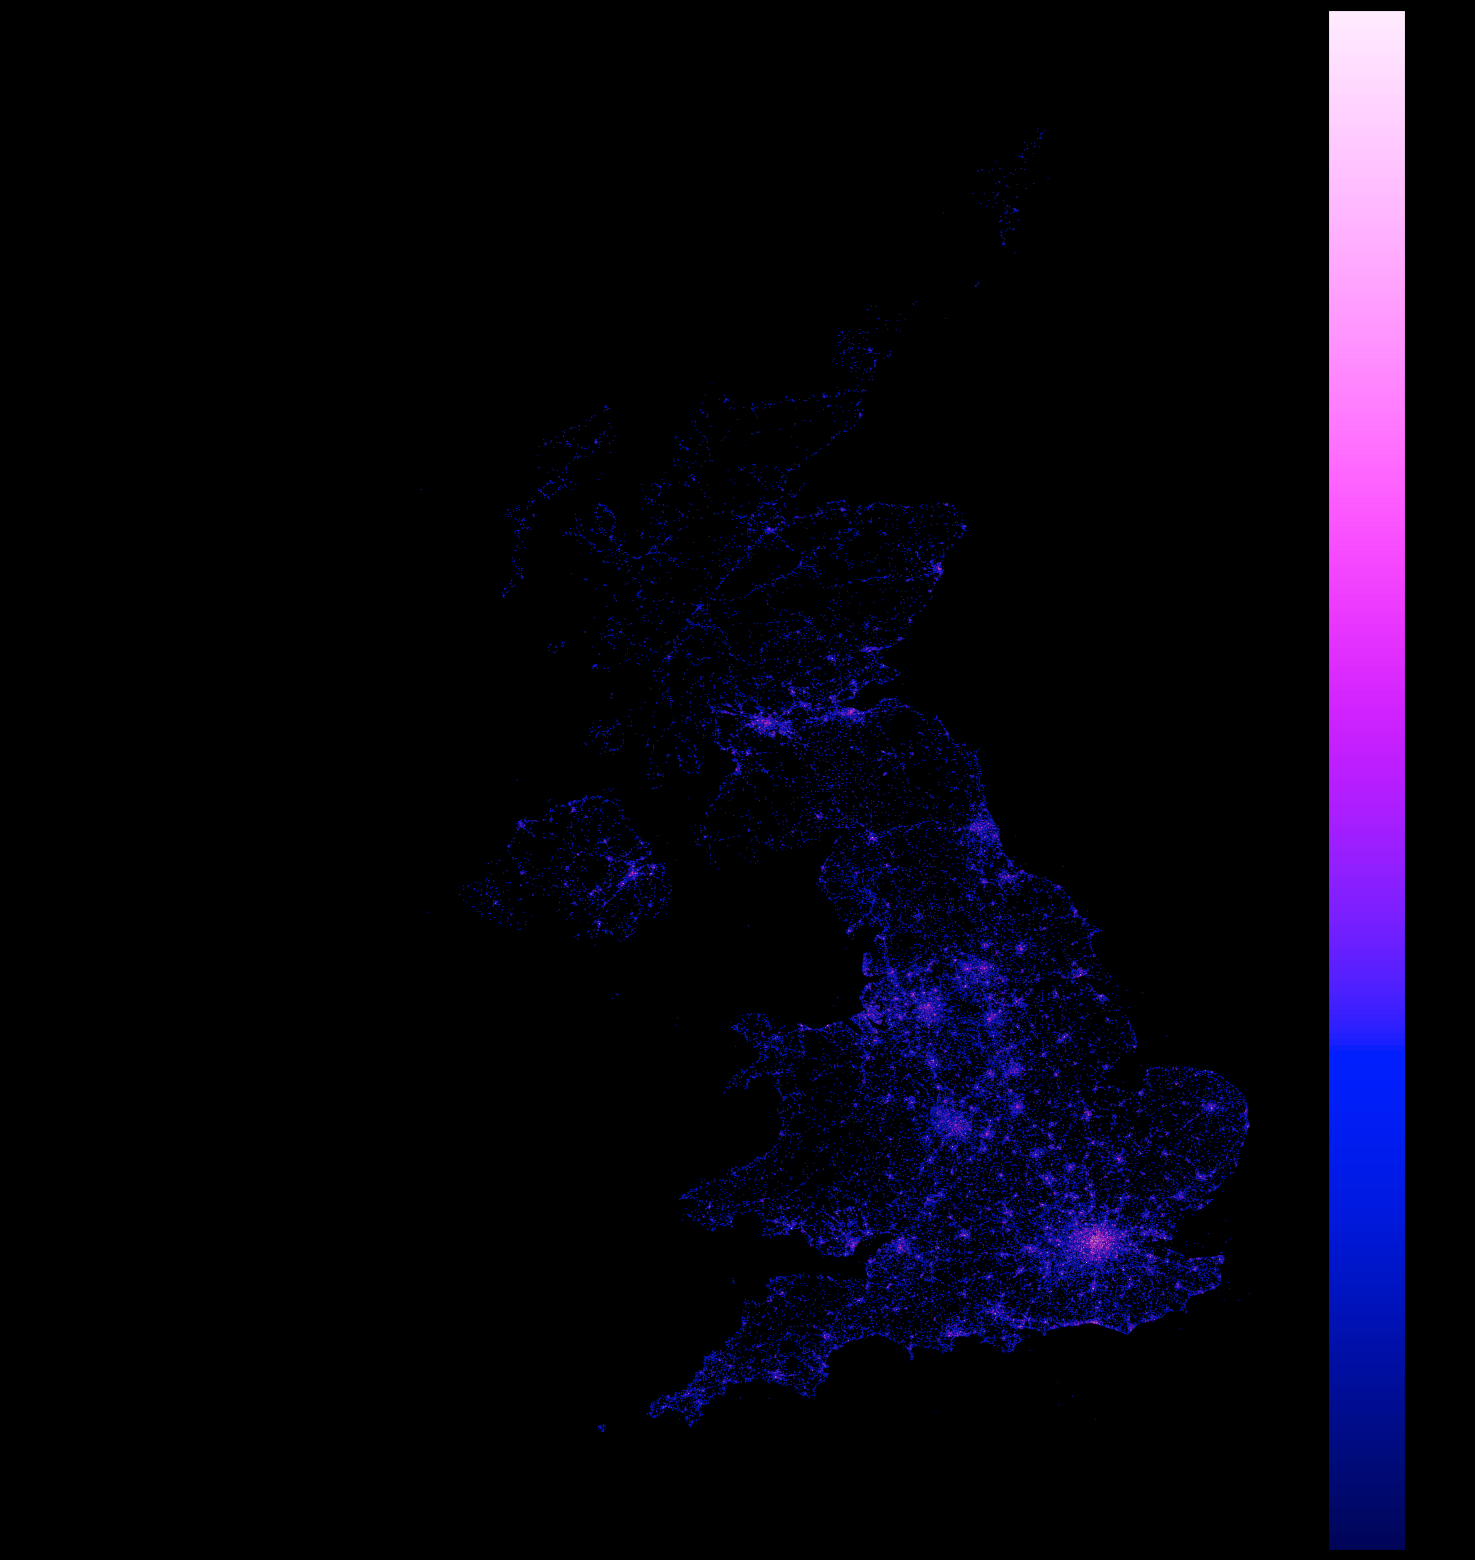

In [40]:
fig, ax = plt.subplots(figsize=(20, 20), facecolor='k')
gdf.plot(column='neighborhood_complexity', cmap=cc.cm.bmw, legend=True, ax=ax)
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])
ax.set_axis_off()
ax.set_facecolor('k')